# VQ-VAE / VQ-VAE2

## Problem: posterior collapse

Data transmitted by the encoder are __noisy or weak__.

The decoder becomes __almost independent__ wrt the encoded $\mu$ and $\sigma$.

## Proposed solution

### Vector Quantization

Force the "signal" to be a classification-like one.

Substitute $h$ continuous with $h$ finite. This way $q(h|x)$ becomes a classifier.

Store quantized representations of embedded features, using a trained embedding sub-space (codebook).

<img src="images/vq-vae.png" width="700pt"/>

### The loss

All the weights must be tuned: __encoder__, __decoder__, __codebook__.

Different constraints described in the loss function:

- __encoder__ must exploit as much as possible the information in the codebook (commitment);
- __codebook__ must be as useful as possible;
- __decoder__ reconstruction must be similar to the original image.

This leads to the following loss:

\begin{eqnarray}
    \Large \mathcal{E}(x,e) &=& \Large \|sg[e]-E[x]\|^2 \\
    \Large \mathcal{C}(x,e) &=& \Large \|e-sg[E(x)]\|^2 \\
    \Large \mathcal{D}(x,e) &=& \Large \|x-D(e)\|^2 \\
    \Large \mathcal{L}(x,e) &=& \Large \mathcal{E}(x,e) + \mathcal{C}(x,e) +\beta\mathcal{D}(x,e) \\
\end{eqnarray}

### The encoder/decoder structure

Some modifications to the vanilla CNNs proposed in the VAE:

- striding instead of pooling;
- batch-normalizations;
- residual blocks;
- transposed convolutions;
- tanh.

In [ ]:
%load_ext autoreload

In [88]:
# %autoreload

from VQ_VAE import train, VqVae

vae, train_losses, test_losses = train(
    model=VqVae(hidden_dim=8, latent_vectors=16),
    epochs=10,
    checkpoint_path='generated/vqvae'
)

Epoch: 1, Train loss: 0.008278786946833134, Test loss: 0.0027494595646858216
Epoch: 2, Train loss: 0.0019142208345234394, Test loss: 0.0015985470227897168
Epoch: 3, Train loss: 0.0014161525985846917, Test loss: 0.0012592479489743709
Epoch: 4, Train loss: 0.0011147220659380157, Test loss: 0.0009683960996568203
Epoch: 5, Train loss: 0.0008672330062836408, Test loss: 0.0007919883586466313
Epoch: 6, Train loss: 0.0007176611241574088, Test loss: 0.0006440996993333101
Epoch: 7, Train loss: 0.0005968562366440892, Test loss: 0.0005495424047112465
Epoch: 8, Train loss: 0.0005201719097793102, Test loss: 0.0004984530031681061
Epoch: 9, Train loss: 0.0004894585680526992, Test loss: 0.0004749897599220276
Epoch: 10, Train loss: 0.0004710820785102745, Test loss: 0.0004566911343485117


In [120]:
from VAE import save_model

save_model(
    'generated/vqvae/',
    vae, train_losses, test_losses
)

In [121]:
from VAE import load_model
from VQ_VAE import VqVae

vae, train_losses, test_losses = load_model(
    'generated/vqvae/', VqVae(hidden_dim=8, latent_vectors=16))

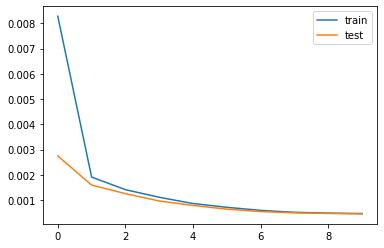

In [122]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train','test'])
plt.show();

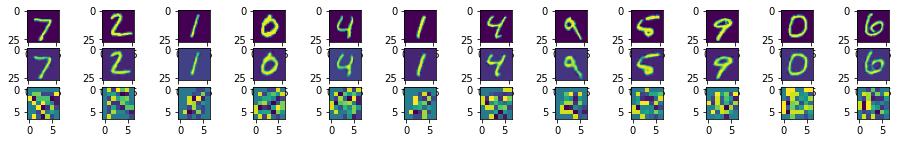

In [123]:
#%autoreload

from VAE import mnist_loader
import torch

# Showing some results:
data_loader = mnist_loader()
_, ax = plt.subplots(3, 12, figsize=(16,2))
for i in range(12):
    img, _ = data_loader.dataset[i]
    ax[0,i].imshow(img.permute(1,2,0))
    with torch.no_grad():
        img = torch.unsqueeze(img,0)
        out, _, _, inds = vae(img)
        out = torch.squeeze(out,0)
    ax[1,i].imshow(out.permute(1,2,0))
    ax[2,i].imshow(inds.reshape((7,7)))

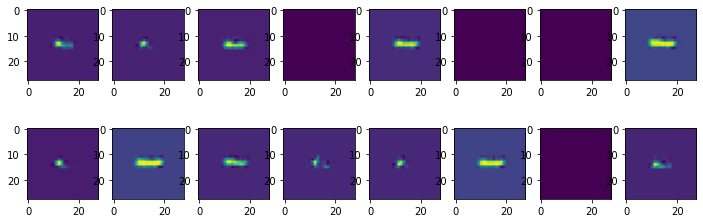

In [124]:
from torch import randint
from matplotlib import pyplot as plt

# The single vectors allow to trace strokes:
inds = torch.zeros((49,), dtype=torch.int32)
with torch.no_grad():
    _, axs = plt.subplots(2,8, figsize=(12,4))
    for i, ax in enumerate(axs.flatten()):
        inds[:] = 14 # In this run this represents the empty image:
        inds[23:26] = i
        emb = vae.codebook.encode(inds)
        img = vae.decoder(emb)
        img = torch.squeeze(img,0).permute(1,2,0)
        ax.imshow(img)
    plt.show()

## Generating new samples

Generating random codes we get random junk:

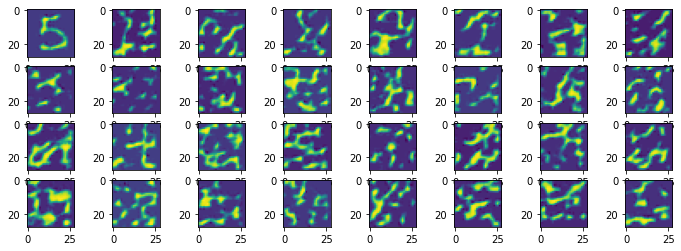

In [125]:
from torch import randint
from matplotlib import pyplot as plt

# Just the first is real:
img, _ = data_loader.dataset[i]
img = torch.unsqueeze(img,0)
_, _, _, inds = vae(img)

# The remaining ones are random:
with torch.no_grad():
    _, axs = plt.subplots(4,8, figsize=(12,4))
    for ax in axs.flatten():
        emb = vae.codebook.encode(inds)
        img = vae.decoder(emb)
        img = torch.squeeze(img,0).permute(1,2,0)
        ax.imshow(img)
        inds = randint(16, (49,))
    plt.show()

## How can we generate the indices?

We compressed the images from 28*28=784 bytes to 7*7=48 integers with 4bits = 24 bytes.. __3%__
...there is lot of room for more compression, both in the VAE and in indices.

We have $\large emb = q(z|x)$ that is our compressed image.

__We do not have the distribution of $\large q(z|x)$.__

We apply another generator model: the __gated pixel CNN__.

### PixelCNN

Introduced by google in the 2016: https://arxiv.org/pdf/1601.06759.pdf

Based on the idea of generation from a conditional probability $p(pixel|context)$:

<img src="images/PixCNNprob.png" width="300pt"/>

Context can be multi-scale:

<img src="images/PixCNN.png" width="400pt"/>

### Gated PixelCNN

Improvement by google in the 2016 https://arxiv.org/pdf/1606.05328.pdf

Manages the blind spot problem:

<img src="images/GPixCNNStacks.jpg" width="400pt"/>

Replaces convolutions with gated activation units (one per stack):

<img src="images/GatedPixCNN.jpg" width="700pt"/>


In [192]:
from VAE import load_model
from VQ_VAE import VqVae

# The pretrained VAE is needed:
vae, train_losses, test_losses = load_model(
    'generated/vqvae/', VqVae(hidden_dim=8, latent_vectors=16))

In [205]:
from VQ_VAE import generate_embedding_files

generate_embedding_files(vae, is_train=True)
generate_embedding_files(vae, is_train=False)

Saved train embeddings
Saved test embeddings


In [249]:
from VQ_VAE import EmbeddingDataset

# Loading the embeddings as a dataset:
ds_test = EmbeddingDataset('generated/vqvae/embedding_test.pt')
ds_test[0]

(tensor([[ 6,  6,  6,  6,  6,  6,  6],
         [ 6, 11, 11,  3,  3,  3, 14],
         [14,  0, 10, 10, 10,  0,  1],
         [ 6, 14,  6, 14,  9,  6,  1],
         [ 6,  6, 14,  0,  2, 12,  3],
         [ 6,  6,  3, 13,  5,  8,  6],
         [ 6, 14,  4,  0, 12,  3,  6]]),
 tensor([7]))

In [371]:
%autoreload

from VQ_VAE_sampling import GatedPixelCNN, train as train_gpcnn

# Training the GatedPixelCNN:
pix, train_losses, test_losses = train_gpcnn(
    GatedPixelCNN(n_layers=6),
    epochs=20,
    batch_size=64, 
    checkpoint_path='generated/vqvae_gpcnn'
)

Epoch: 1, Train loss: 0.0231235111673673, Test loss: 0.01894434440135956
Epoch: 2, Train loss: 0.018214347447951636, Test loss: 0.0175114532828331
Epoch: 3, Train loss: 0.017329612829287848, Test loss: 0.01693868653178215
Epoch: 4, Train loss: 0.016889417564868926, Test loss: 0.016644883078336715
Epoch: 5, Train loss: 0.016601852640509604, Test loss: 0.016360548835992812
Epoch: 6, Train loss: 0.01639276039103667, Test loss: 0.016176842284202575
Epoch: 7, Train loss: 0.01623232036928336, Test loss: 0.01607571393251419
Epoch: 8, Train loss: 0.016107374744613965, Test loss: 0.015953116285800935
Epoch: 9, Train loss: 0.016012717376152674, Test loss: 0.015854390966892243
Epoch: 10, Train loss: 0.015919286091128984, Test loss: 0.01580311449766159
Epoch: 11, Train loss: 0.0158494674940904, Test loss: 0.015743372136354447
Epoch: 12, Train loss: 0.01578820586601893, Test loss: 0.015699524641036987
Epoch: 13, Train loss: 0.015724774552385013, Test loss: 0.01560095967054367
Epoch: 14, Train loss:

In [374]:
from VAE import save_model

save_model(
    'generated/vqvae_gpcnn/',
    pix, train_losses, test_losses
)

In [376]:
from VAE import load_model
from VQ_VAE import VqVae

pix, train_losses, test_losses = load_model(
    'generated/vqvae_gpcnn/', GatedPixelCNN(n_layers=6))

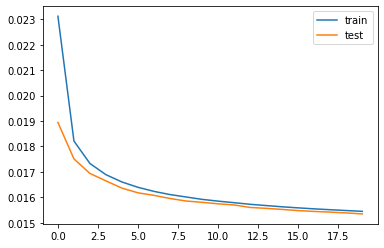

In [377]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train','test'])
plt.show();

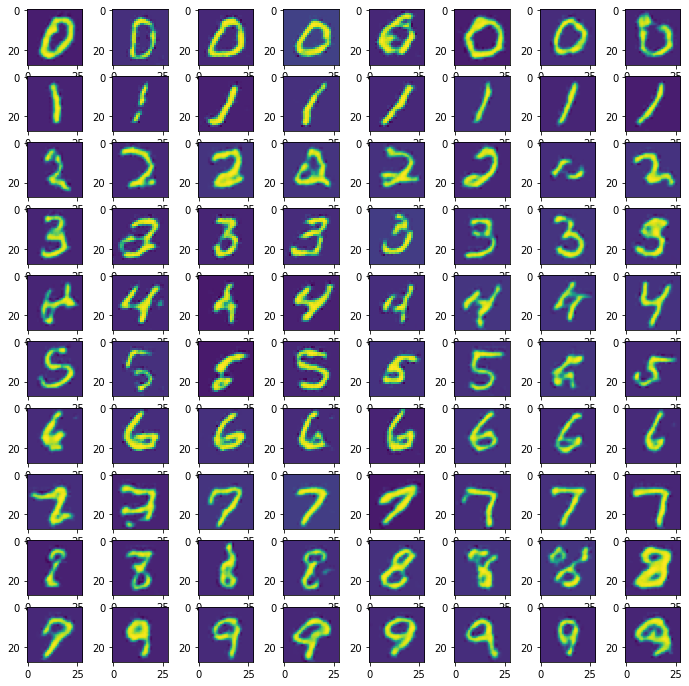

In [379]:
%autoreload

from torch import randint
from matplotlib import pyplot as plt

bs = 8
with torch.no_grad():
    _, axs = plt.subplots(10,indexes.shape[0], figsize=(12,12))
    for label in range(10):
        indexes = pix.generate(label=[label]*bs,batch_size=bs)
        for i, ax in enumerate(axs[label]):
            inds = indexes[i].flatten()
            emb = vae.codebook.encode(inds)
            img = vae.decoder(emb)
            img = torch.squeeze(img,0).permute(1,2,0)
            ax.imshow(img)
    plt.show()

# VQ-VAE2

Recently (2019) a new version of VQ-VAE have been proposed with the following main changes:

- hierarchical approach;
- prior for latent codes initialization.

<img src="images/vq-vae2.jpeg" width="400pt"/>

These changes allow for much more realistic fakes.

See https://arxiv.org/pdf/1906.00446v1.pdf